In [ ]:
%%capture
!pip install amazon-braket-sdk matplotlib quera_ahs_utils

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from quera_ahs_utils.plotting import show_register, show_global_drive, show_final_avg_density
from quera_ahs_utils.drive import get_drive



In [ ]:
def open_json(json_file):
    '''
    Helper function to load and open json data
    '''
    with open(json_file,"r") as io:
        return json.load(io)
def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      }
        result_dict["measurements"].append(shot_result)

    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)
def postprocess_MIS(G,results):
    '''
    Removes vertices that violate the independent set condition
    G - networkx graph
    results - an AWS AnalogHamiltonianSimulationQuantumTaskResult

    returns
    data_out - a list of bitstrings which are valid independent sets of G
    '''
    data_out = []
    for measurement in results["measurements"]: # For each measurement...
        pre_sequence = np.array(measurement["pre_sequence"])
        post_sequence = np.array(measurement["post_sequence"])
        if np.any(pre_sequence==0): continue # skip anyshots with defects

        bitstring = post_sequence
        inds = np.nonzero(bitstring==0)[0]    # Find indices of IS vertices
        subgraph = nx.subgraph(G,inds)        # Generate a subgraph from those vertices. If the bitstring is an independent set, this subgraph has no edges.
        inds2 = nx.maximal_independent_set(subgraph,seed=0) # Find the mIS of this subgraph. If there are no edges, it is the original bitstring. Else, it randomly chooses within each graph.
        payload = np.ones(len(bitstring))     # Forge into the correct data structure (a list of 1s and 0s)
        payload[inds2] = 0
        data_out.append(payload)

    if len(data_out) == 0:
        raise ValueError("no independent sets found! increase number of shots.")

    return np.asarray(data_out)

def analysis_MIS(graph,result_json):
    '''
    Helper function to analyze a MIS result and plot data
    '''

    post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
    pp_bitstrings = postprocess_MIS(graph, result_json)


    IS_sizes = np.sum(1-pp_bitstrings,axis=1)
    unique_IS_sizes,counts = np.unique(IS_sizes,return_counts=True)


    avg_no_pp = 'Average pre-processed size:  {:0.4f}'.format( (1-post_bitstrings).sum(axis=1).mean() )
    avg_pp = 'Average post-processed IS size: {:0.4f}'.format(IS_sizes.mean())
    print(avg_no_pp)
    print(avg_pp)
    plt.bar(unique_IS_sizes,counts/counts.sum())
    plt.xticks(unique_IS_sizes)
    plt.xlabel("IS sizes",fontsize=14)
    plt.ylabel("probability",fontsize=14)
    plt.show()

    return IS_sizes,pp_bitstrings

def visualize_graph(ax,graph,positions,node_colors = "#6437FF"):
    '''
    Visualize a graph using networkx
    ax          - matplotlib axis to draw on
    graph       - networkx graph of vertices and edges, with vertex labels as integers
    positions   - Positions of each vertex
    node_colors - Color of nodes. Either a string, or list of strings, one for each vertex
    '''

    ax.set_aspect('equal')
    ax.axis('off')

    pos_dict = {a:positions[a] for a in range(positions.shape[0])}
    nx.draw_networkx_edges(graph,pos_dict,width=10/np.sqrt(len(graph.nodes)))
    nx.draw_networkx_nodes(graph,pos_dict,node_size=1225/np.sqrt(len(graph.nodes)),node_color=node_colors)
def find_UDG_radius(position, graph):
    '''
    Computes the optimal unit disk radius for a particular set of positions and graph.
    position   - [N x 2] array of points
    graph       - network connectivity graph. This should be a unit disk graph.

    returns
    radius      - Optimal unit disk radius of the graph
    rmin        - Minimum distance
    rmax        - Maximum distance
    '''

    dists = np.sqrt((position[:,0,None] - position[:,0])**2
               + (position[:,1,None] - position[:,1])**2)
    rmin = 0
    rmax = np.inf
    for i in range(position.shape[0]):
        for j in range(i+1,position.shape[0]):
            if (i,j) in graph.edges:
                if rmin<dists[i,j]:
                    rmin = dists[i,j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i,j]:
                    rmax = dists[i,j]

    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")

    return np.sqrt(rmin*rmax),rmin,rmax

In [ ]:
house_position = [
    (252, 155), (252, 259),
    (261, 65), (283, 560), (346, 78), (386, 639), (401, 378),
    (401, 520), (401, 776), (416, 242), (465, 128), (465, 708),
    (481, 402), (510, 617), (533, 210), (533, 537), (533, 793),
    (545, 460), (570, 302)
]

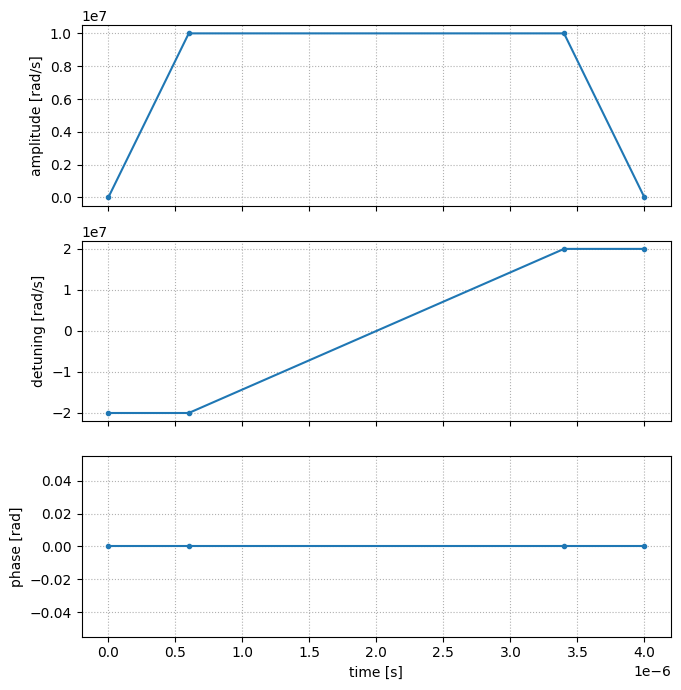

In [ ]:
qpu = LocalSimulator("braket_ahs")
C6 = 5.4E-24 #coeficiente de interação do átomo de Rydberg
Delta_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = (C6/(Delta_final))**(1/6)
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
Delta_initial = -20e6     # rad / sec
Delta_final = Delta_final # Defined above

# Define the total drive
from quera_ahs_utils.plotting import show_register, show_global_drive, show_final_avg_density
from quera_ahs_utils.drive import get_drive

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [Delta_initial, Delta_initial, Delta_final, Delta_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [ ]:
# Formatação no mesmo estilo do arquivo coordenadas_sistema_B.json
formatted_data = {
    "position": [[float(x), float(y)] for x, y in house_position]
}

# Nome do arquivo para salvar
output_file = "house_coordinates.json"

# Salvando no arquivo JSON
with open(output_file, "w") as file:
    json.dump(formatted_data, file, indent=4)

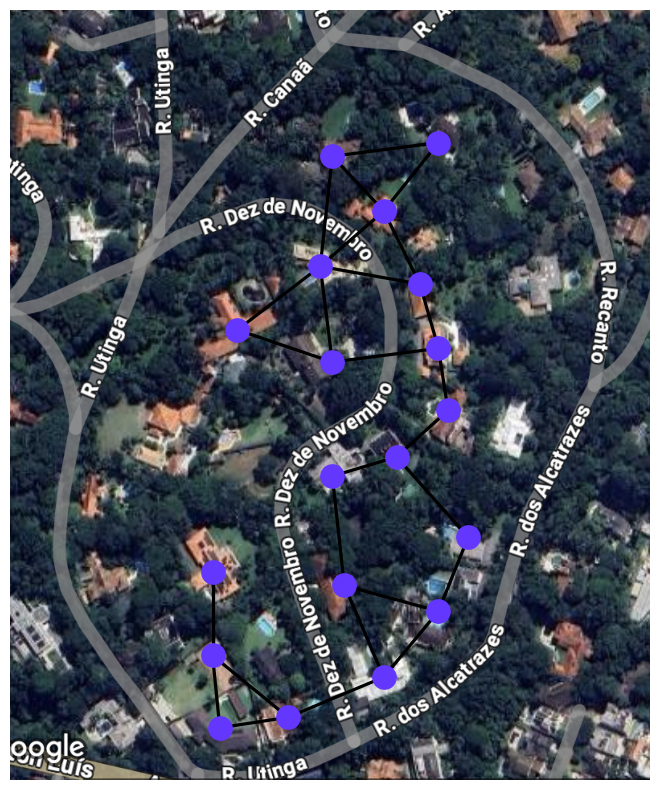

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('mapa.png')
downtown = open_json("house_coordinates.json")
coordinates = np.array(downtown["position"])
unitdisk_radius = 140 # meters
# Construct a unit disk graph as no two sites within 1500 feet of each other
distances = np.sqrt((coordinates[:,0] - coordinates[:,0,None])**2
                    + (coordinates[:,1] - coordinates[:,1,None])**2)
G = nx.Graph(distances<unitdisk_radius)
G.remove_edges_from(nx.selfloop_edges(G))
G = nx.relabel.convert_node_labels_to_integers(G)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
visualize_graph(ax,G,coordinates)
plt.imshow(img,extent=[0,796,0,958])
plt.show()

Unit disk radius of logical graph is 139.894
Blockade radius is 8.039e-06
Scaling factor is 17400870.966um/m


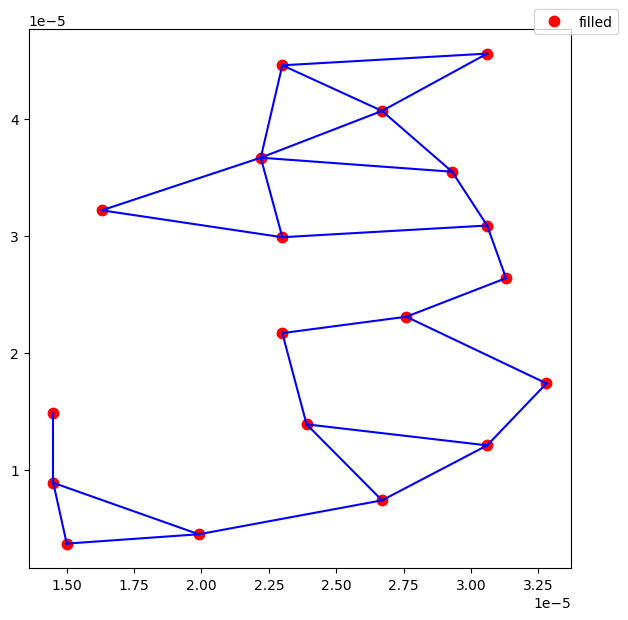

In [ ]:
# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(coordinates,G)
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))
print('Blockade radius is {:0.3e}'.format(blockade_radius))
a = blockade_radius / unitdisk_radius
print('Scaling factor is {:0.3f}um/m'.format(1/a))
register = AtomArrangement()
for x in coordinates:
    register.add([round(a * x[0],7), round(a*x[1],7)])
show_register(register,blockade_radius = blockade_radius,show_atom_index=False)

ahs_program = AnalogHamiltonianSimulation(
    register=register,
    hamiltonian=drive
)

In [ ]:
nshots = 10
task = qpu.run(ahs_program, shots=nshots)
print(task)

save_result_json("resposta_mis.json",task.result())

KeyboardInterrupt: 

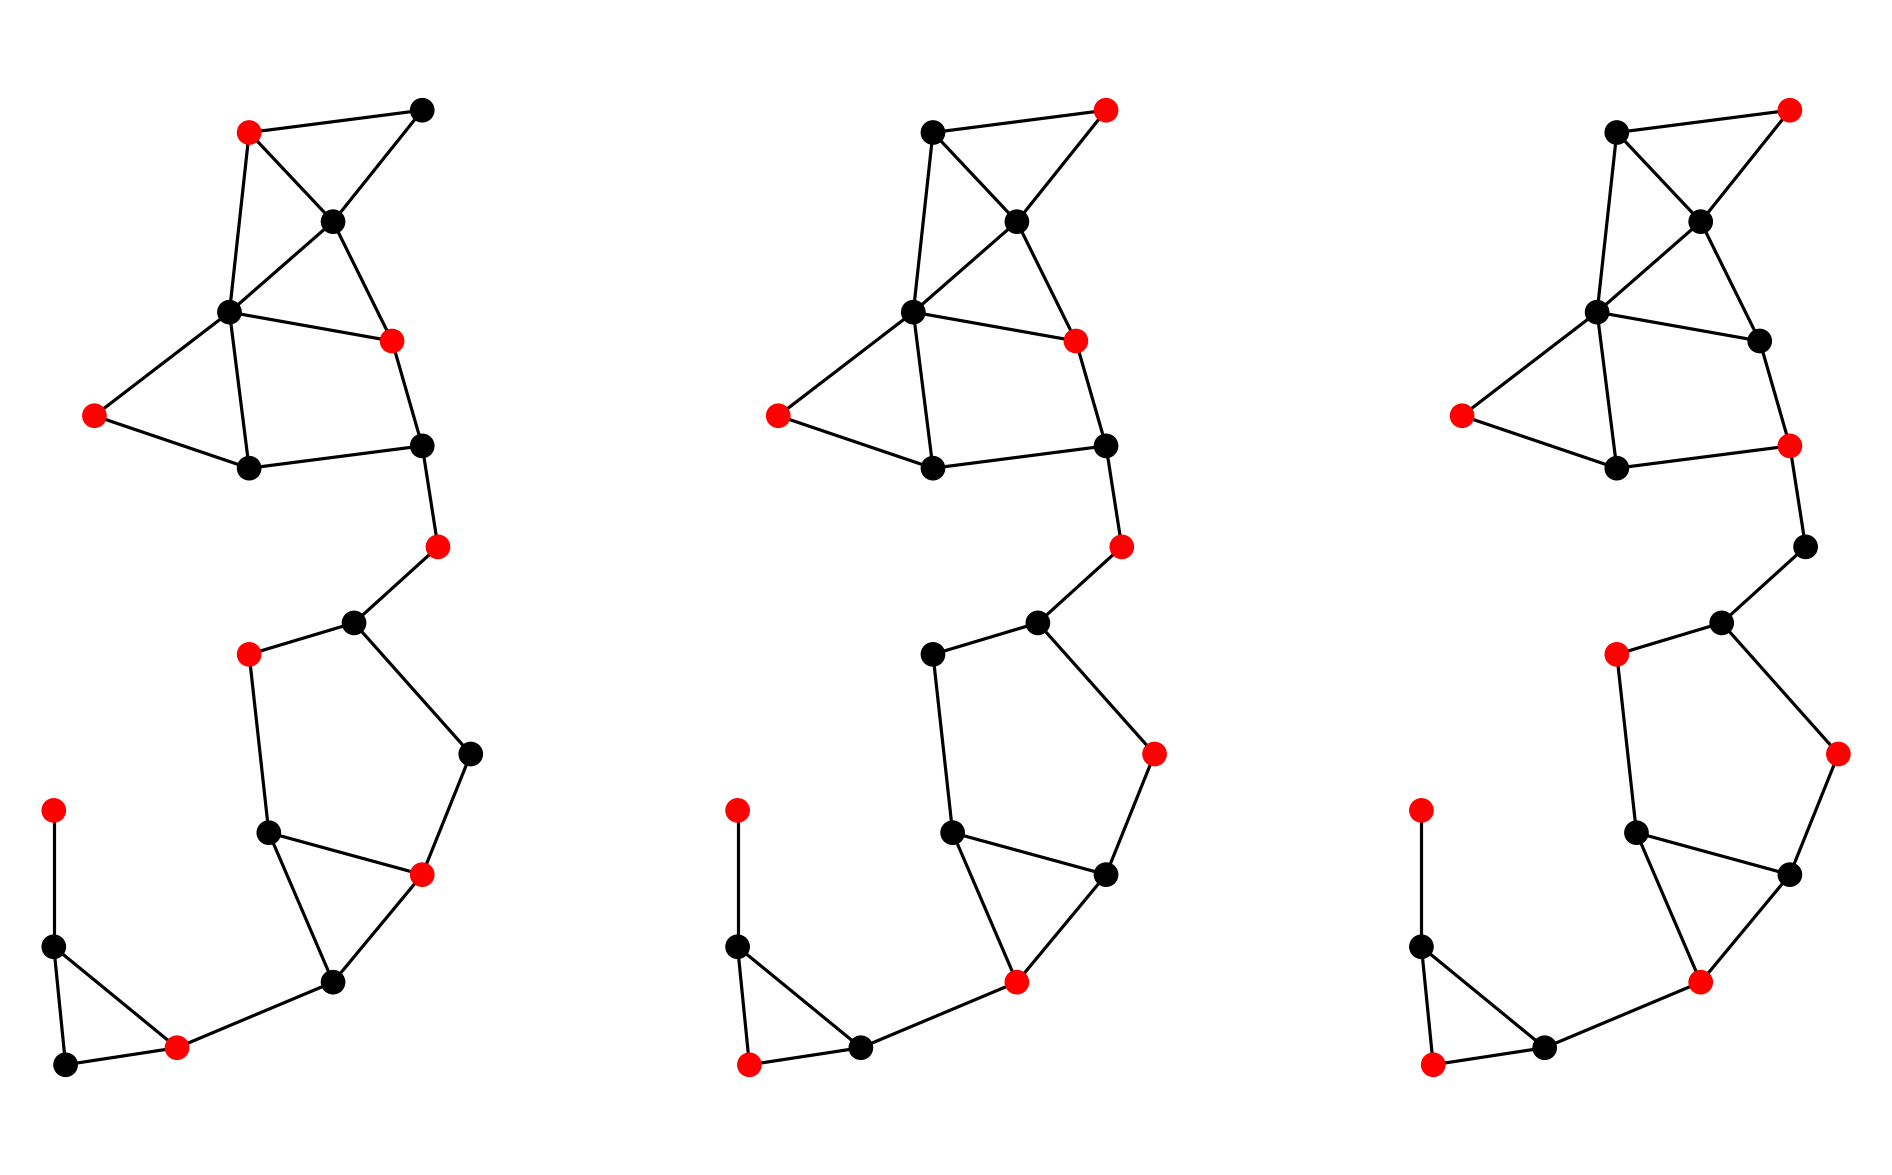

In [ ]:
result_json = open_json("resposta_mis.json")

seqs = [result_json["measurements"][i]["post_sequence"] for i in range(3)]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,G,coordinates,node_colors = seqs_color)
plt.show()

Average pre-processed size:  8.3000
Average post-processed IS size: 8.2000


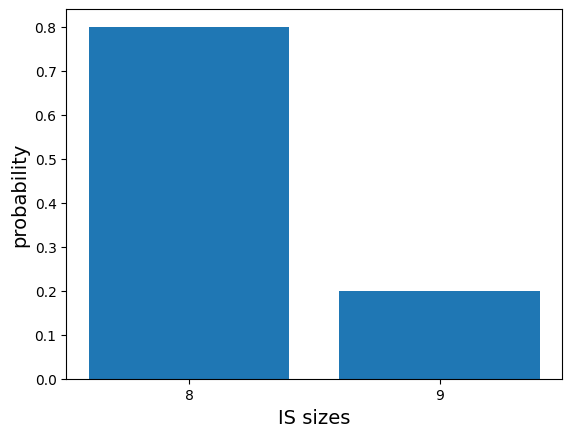

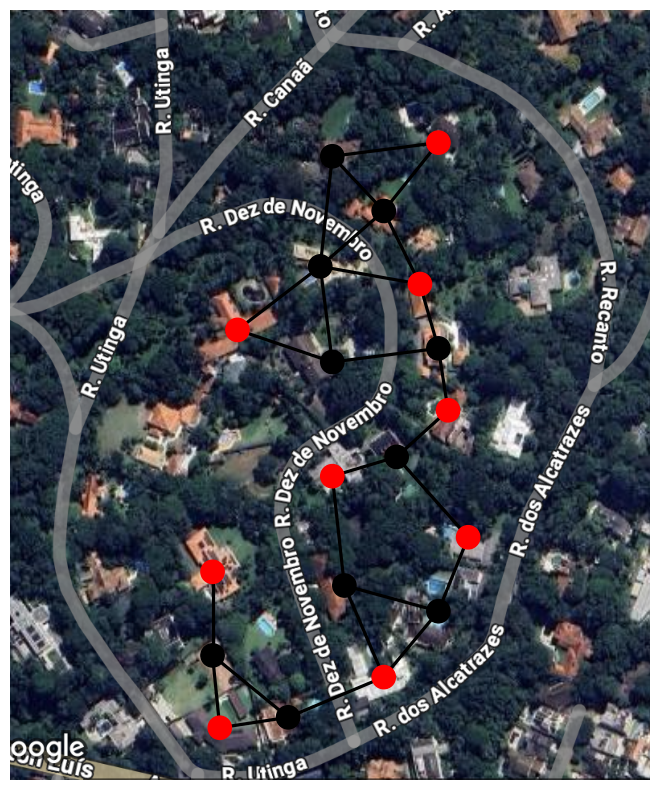

In [ ]:
result_json = open_json("resposta_mis.json")
IS_sizes,pp_bitstrings = analysis_MIS(G,result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = 1

fig = plt.figure(figsize=(10,10))
for i in range(n_show):
    ax = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(ax,G,coordinates,node_colors = seqs_color)
    plt.imshow(img,extent=[0,796,0,958])

plt.show()